#### This notebook compares rescaling of zstack using static theories or a dynamic scaling factor theory.
###### We use microscopy data of beads stuck in agarose to compare theories.
###### The comparison is made between stacks recorded with a water objective (ground truth) and an oil objective.

###### First, we import packages and functions:

In [1]:
import psf_extra as psfe
import numpy as np
import matplotlib.pyplot as plt

from utils import *

###### Next, we import the data:

In [2]:
#load stacks
location = '../SF/bead_stack_data/20231020/new_crops/' #location of stacks
gt_stack = psfe.load_stack(location+'water_stack_crop2_cs_206.tif')
distorted_stack = psfe.load_stack(location+'oil_stack_crop_2_cs_208.tif')

shape_gt = np.shape(gt_stack)
shape_distorted = np.shape(distorted_stack)

# The cover slip should be at the last z-slice 
# To check: (this should an image of the beads on the cover slip)
#plt.imshow(gt_stack[-1])
#plt.show()

#Then, if necessary: invert z direction
#gt_stack = gt_stack[::-1, :, :]
#distorted_stack = distorted_stack[::-1, :, :]

if len(shape_gt) > 3:
    gt_stack = gt_stack[:,:,:,0]
    shape_gt = np.shape(gt_stack)
if len(shape_distorted) > 3:
    distorted_stack = distorted_stack[:,:,:,0]
    shape_distorted = np.shape(distorted_stack)

print('Done!')

Done!


###### Next, we set the parameters of the data:

In [13]:
medium_gt = 'water'
ps_xy_gt = 0.1553701 # um
ps_z_gt = 0.5 # um

medium_distorted = 'oil'
ps_xy_distorted = 0.1242961 # um
ps_z_distorted = 0.5 # um

n_im = 1.518
n_sample = 1.3358 # 2w% agarose in water - https://www.nature.com/articles/s41598-020-64103-3
lam_0 = 0.52 # microns
NA = 1.4

###### As the axial distorted z-stack with a refractive index mismatch suffers from intensity loss as a function of depth, we rescale the intensity as a function of the depth:

In [14]:
distorted_stack_comp,_,_ = compensate_int_loss(distorted_stack,kernel_size=25,fit=False,skip_slides=20, plot=False)

#normalize to match histogram of gt stack:
factor = .3 # used to optimize histogram matching (see next cell)
distorted_stack_comp=distorted_stack_comp/(np.max(distorted_stack_comp)*factor)

#saturated values higher than 1 (for easier plotting):
distorted_stack_comp[distorted_stack_comp>1.0]=1.0

###### Optionally, check the intensity histograms of the ground truth stack and the distorted stack:
###### (This is a bit slow for large stacks...)

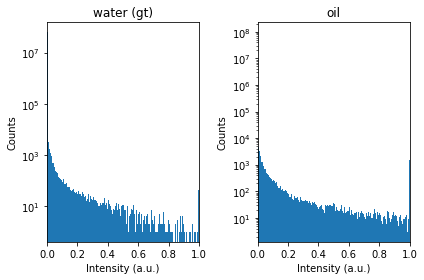

In [17]:
plot_int_histograms(gt_stack,distorted_stack_comp,[medium_gt+' (gt)',medium_distorted])

###### Next we plot the maximum intensity projections of the ground truth and distorted stacks to check the intensity loss compensation:

After intensity loss compensation:


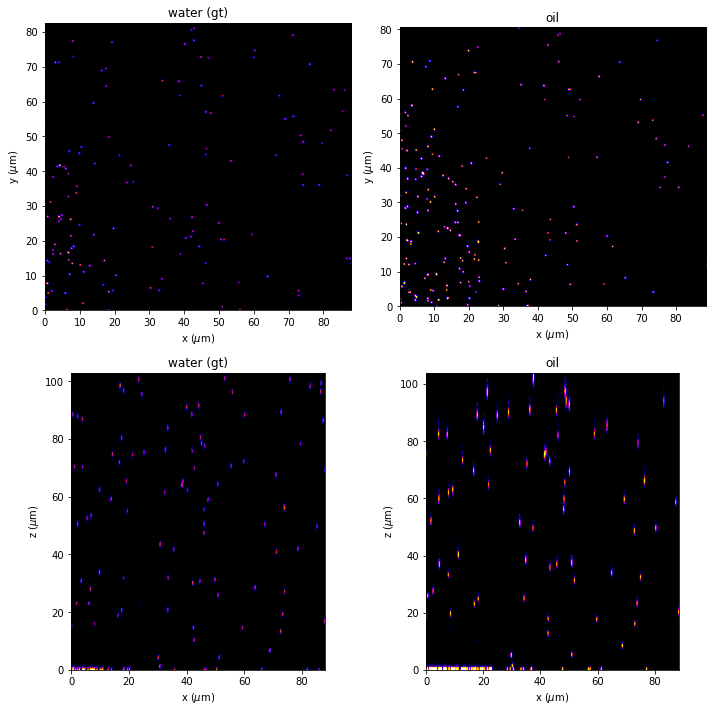

Before intensity loss compensation:


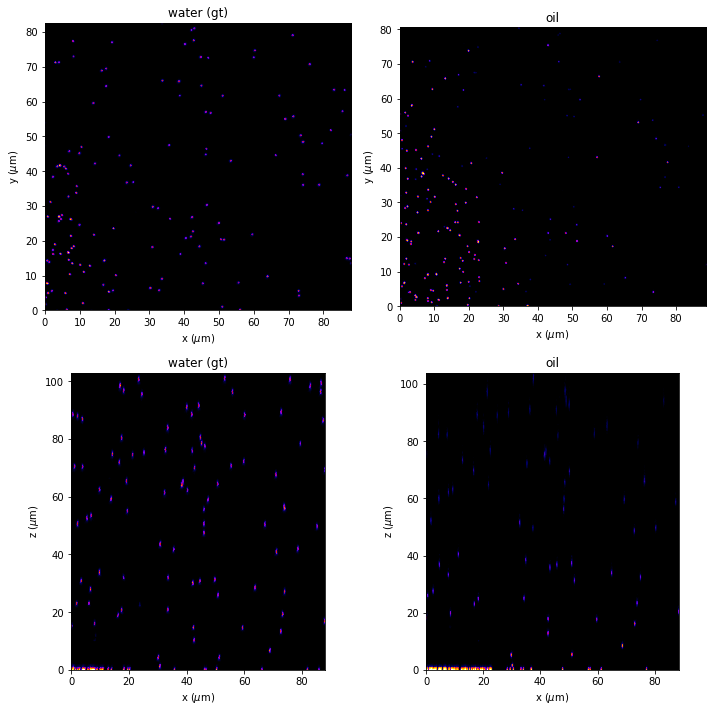

In [18]:
print("After intensity loss compensation:")
plot_stacks_MIPs(gt_stack,distorted_stack_comp,[medium_gt + ' (gt)',medium_distorted], ['xy','xz'], ps_xy_gt, ps_z_gt, ps_xy_distorted, ps_z_distorted)
print("Before intensity loss compensation:")
plot_stacks_MIPs(gt_stack,distorted_stack,[medium_gt + ' (gt)',medium_distorted], ['xy','xz'], ps_xy_gt, ps_z_gt, ps_xy_distorted, ps_z_distorted)

###### Perform the depth-dependent rescaling of the distorted stack:

In [19]:
stack_rescaled, afp_new_stack, afp_stack, nfp_stack = rescale_stack(distorted_stack_comp[::-1], NA, n_im, n_sample, lam_0, ps_z_gt,crit='Lyakin')

###### Plot the overlays of the rescaled data vs the ground truth data for the different theories:

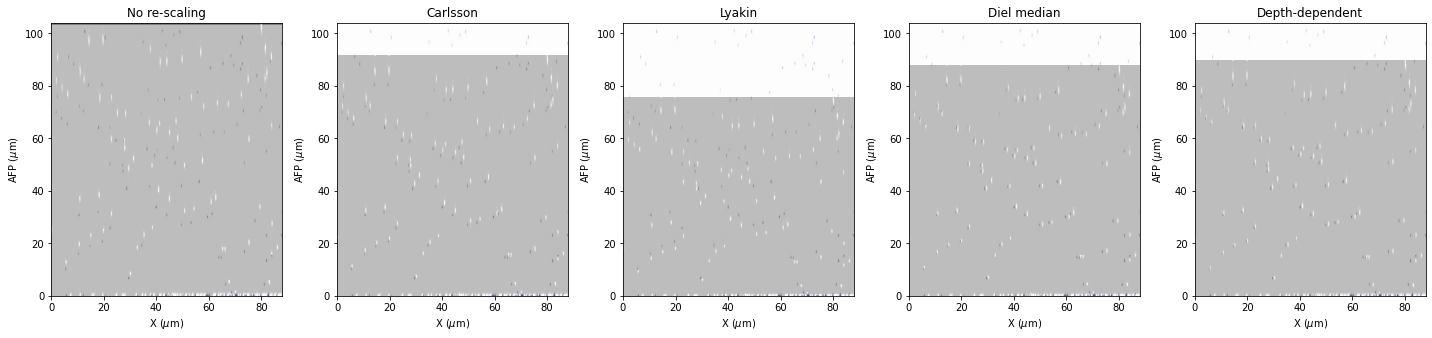

In [20]:
#define pixel sizes of linear re-scaled stacks
ps_z_distorted_diel_median = ps_z_distorted * diel_median([1],n_im,n_sample,NA)[0]
if n_sample > NA: ps_z_distorted_diel_mean = ps_z_distorted * diel_mean([1],n_im,n_sample,NA)[0]
else: ps_z_distorted_diel_mean = 0
ps_z_distorted_lyakin = ps_z_distorted * Lyakin([1],n_sample,n_im,NA)[0]

#define theories and corresponding pixel sizes for plotting:
theories = ['No re-scaling',
            'Carlsson',
            'Stallinga/Lyakin',
            'Diel median', 
            'Diel mean', 
            'Depth-dependent'
           ]
rescaled_ps_z = [ps_z_distorted, 
                 ps_z_distorted*n_sample/n_im,
                 ps_z_distorted_lyakin,
                 ps_z_distorted_diel_median,
                 ps_z_distorted_diel_mean,
                 ps_z_gt
                ]

if n_sample < NA: # Diel mean does not work when ref. index of sample is smaller than numerical aperture of objective
    theories.remove('Diel mean')
    rescaled_ps_z.remove(ps_z_distorted_diel_mean)
if n_im >= n_sample:
    theories = list(map(lambda x: x.replace('Stallinga/Lyakin', 'Lyakin'), theories))

#set y range in plots (optional):
#y_min,y_max = 0, 50

plot_overlay_panels(theories, 
                    distorted_stack_comp,stack_rescaled,gt_stack,
                    ps_xy_distorted,ps_z_distorted,
                    ps_xy_gt,ps_z_gt,
                    rescaled_ps_z,
                    #y_min,y_max     # uncomment this line to set y limits in plot
                    )